# Stroke Prediction Project

In [5]:
import os
print(os.environ['PATH'])

/Users/clanceybarrington/opt/anaconda3/bin:/Users/clanceybarrington/opt/anaconda3/condabin:/usr/bin:/bin:/usr/sbin:/sbin


### Table of Contents

1. [Intro](#Intro)  
2. [Import Packages](#Packages)  
3. [Read in Data](#Data)  
4. [Missing Values](#missing)  
5. [EDA](#eda)  
6. [Preprocessing](#pre)  
7. [Train/ Test Split](#train)  
8. [Feature Scaling](#scale)  
9. [Model Selection](#mod)  
10. [Model Tuning](#mod_tun)  
11. [Model Evaluation](#mod_eval)  
12. [Conclusions](#con)



### Intro <a class="anchor" id="Intro"></a>
This data was aquired from [fedesoriano](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) on kaggle. The goal of this project is to predict stroke in a patient. The variable directory is as follows:  
1) id: unique identifier   
2) gender: "Male", "Female" or "Other"  
3) age: age of the patient  
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension  
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease  
6) ever_married: "No" or "Yes"  
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"  
8) Residence_type: "Rural" or "Urban"  
9) avg_glucose_level: average glucose level in blood  
10) bmi: body mass index  
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"  
12) stroke: 1 if the patient had a stroke or 0 if not  

### Import Packages <a class="anchor" id="Packages"></a>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Read in Data <a class="anchor" id="Data"></a>

In [2]:
stroke = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


After taking a deeper look at the data, we see that there are some missing values for bmi.

In [3]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Missing Values <a class="anchor" id="missing"></a>

I wanted to see how many missing values we had, as well as the percentage of missing values.

In [4]:
stroke.isnull().sum() 

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
round(stroke.isnull().sum() / len(stroke["id"]) * 100, 2)

id                   0.00
gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

I chose to impute my data based on age, since children tend to have a lower bmi. We can see this in the plot below.

<AxesSubplot:xlabel='age', ylabel='bmi'>

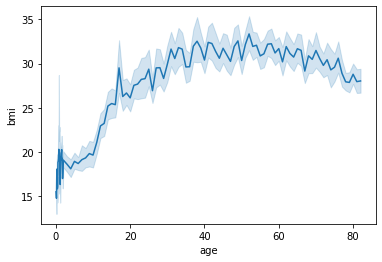

In [6]:
sns.lineplot(x='age', y='bmi', data=stroke)

I made three age groups to compare the bmis. The 18-60 and 60+ have similar bmis, so I will use the mean bmi for each group. 

In [7]:
bins = [0,18, 60, 90]
labels = ['0-17', '18-60', '60+']
stroke['age_range'] = pd.cut(stroke.age, bins, labels = labels,include_lowest = True)

In [8]:
stroke['age_range'][:10]

0      60+
1      60+
2      60+
3    18-60
4      60+
5      60+
6      60+
7      60+
8    18-60
9      60+
Name: age_range, dtype: category
Categories (3, object): ['0-17' < '18-60' < '60+']

<AxesSubplot:xlabel='age_range', ylabel='bmi'>

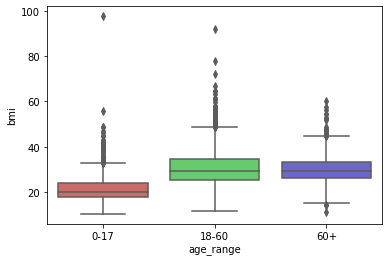

In [9]:
sns.boxplot(x='age_range', y='bmi', data=stroke, palette='hls')

In [10]:
age_groups = stroke.groupby(stroke['age_range'])
age_groups.mean()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age_range,,,,,,,
0-17,36326.597162,9.179039,0.001092,0.001092,94.768395,21.714302,0.002183
18-60,36666.172664,41.258131,0.074394,0.022491,102.581249,30.763926,0.024221
60+,36323.394172,71.506135,0.216258,0.161043,122.045222,29.873377,0.135736


In [11]:
def bmi_approx(cols):
    bmi = cols[0]
    age_range = cols[1]
    
    if pd.isnull(bmi):
        if age_range == "0-17":
            return 22
        else:
            return 30
        
    else:
        return bmi

In [12]:
stroke['bmi']= stroke[['bmi', 'age_range']].apply(bmi_approx, axis=1)
stroke.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_range            0
dtype: int64

### EDA <a class="anchor" id="eda"></a>

<AxesSubplot:xlabel='gender', ylabel='count'>

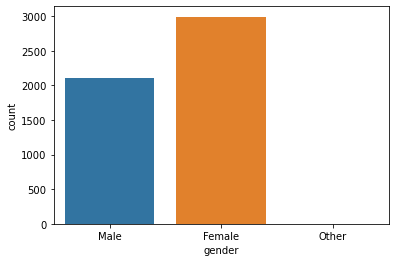

In [13]:
sns.countplot(x = 'gender', data = stroke)

<AxesSubplot:xlabel='ever_married', ylabel='count'>

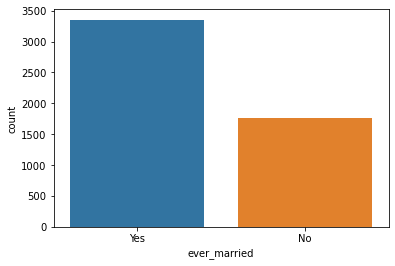

In [14]:
sns.countplot(x = 'ever_married', data = stroke)

<AxesSubplot:xlabel='work_type', ylabel='count'>

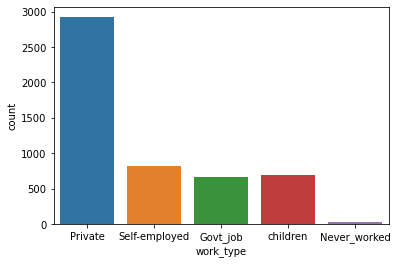

In [15]:
sns.countplot(x = 'work_type', data = stroke)

<AxesSubplot:xlabel='Residence_type', ylabel='count'>

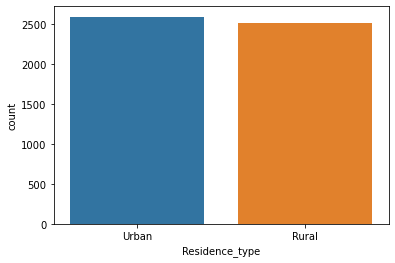

In [16]:
sns.countplot(x = 'Residence_type', data = stroke)

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

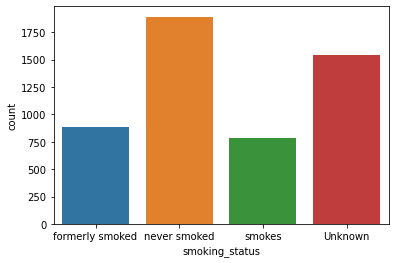

In [17]:
sns.countplot(x = 'smoking_status', data = stroke)

<AxesSubplot:xlabel='hypertension', ylabel='count'>

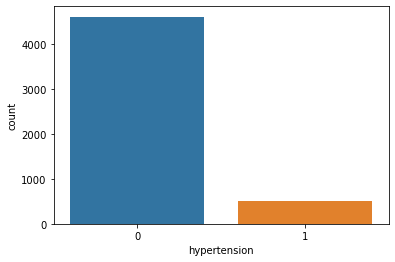

In [18]:
sns.countplot(x = 'hypertension', data = stroke)

<AxesSubplot:xlabel='heart_disease', ylabel='count'>

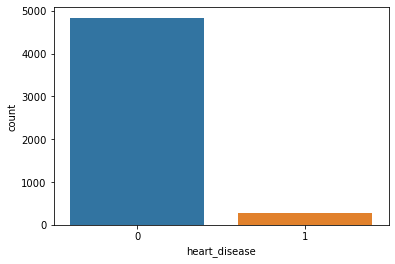

In [19]:
sns.countplot(x = 'heart_disease', data = stroke)

<AxesSubplot:xlabel='age', ylabel='Count'>

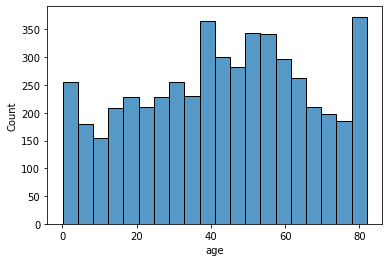

In [20]:
sns.histplot(x = 'age', data = stroke)

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

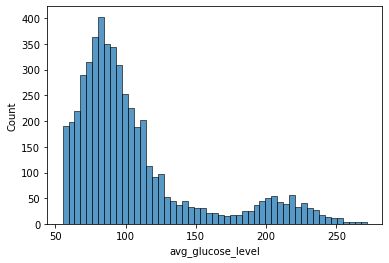

In [21]:
sns.histplot(x = 'avg_glucose_level', data = stroke)

<AxesSubplot:xlabel='bmi', ylabel='Count'>

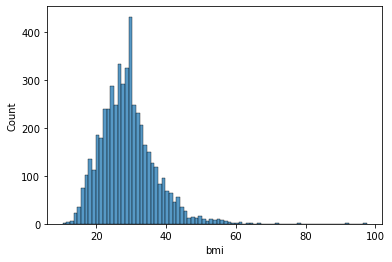

In [22]:
sns.histplot(x = 'bmi', data = stroke)

<Figure size 720x720 with 0 Axes>

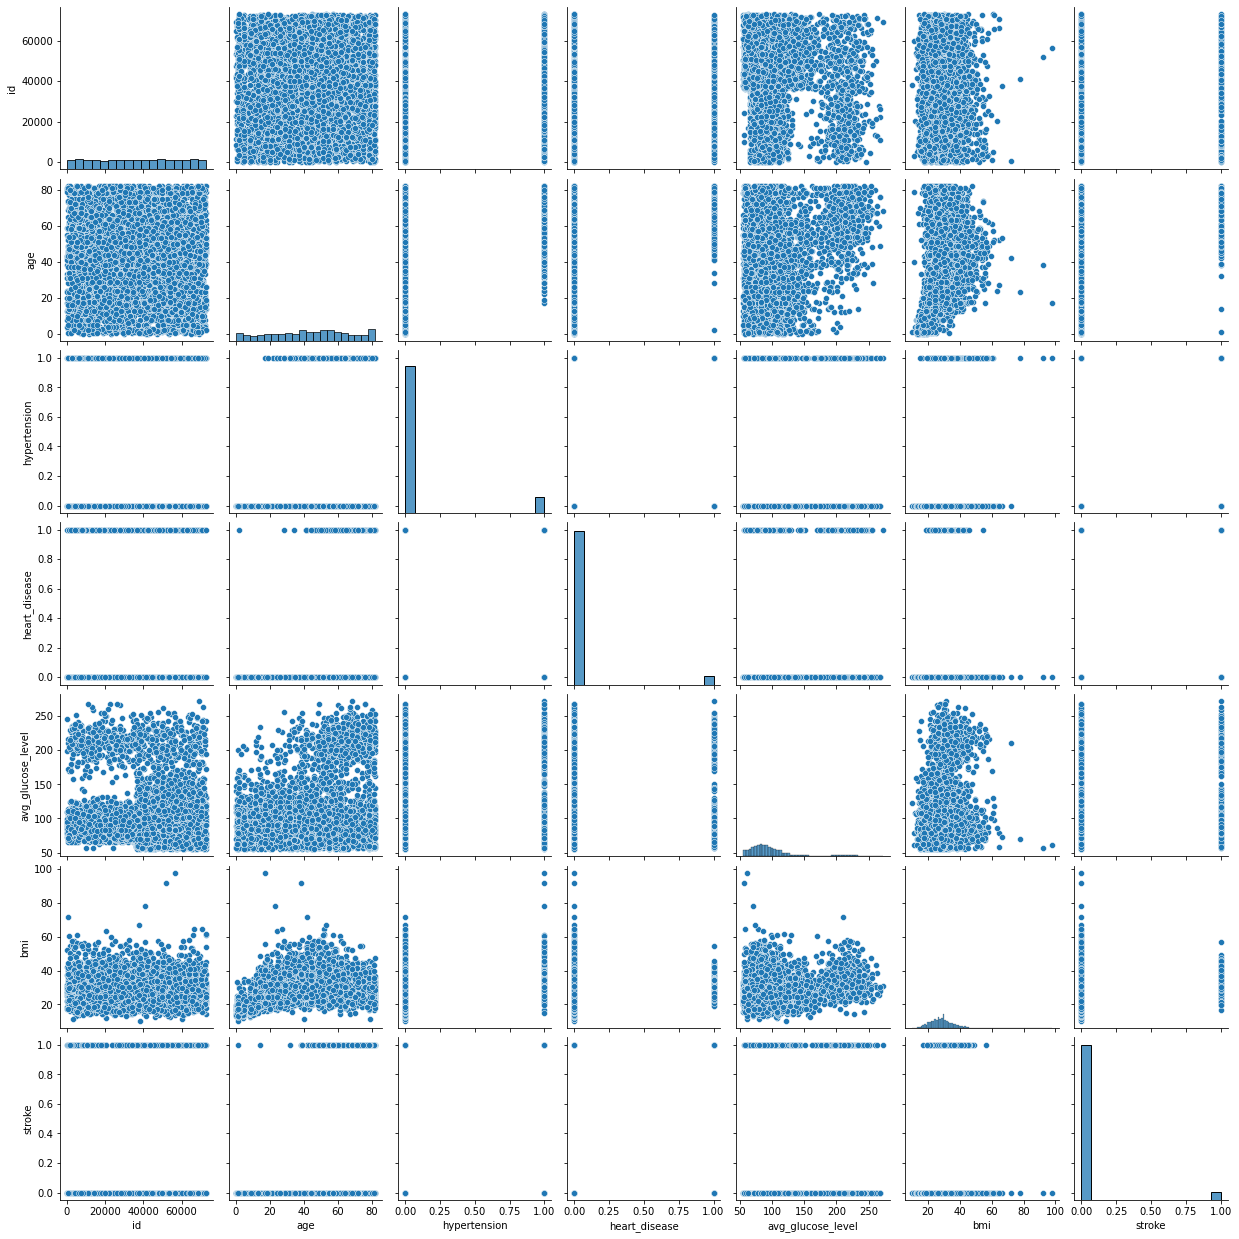

In [23]:
fig = plt.figure(figsize=(10,10))
sns.pairplot(stroke)
plt.show()

### Preprocessing <a class="anchor" id="pre"></a>

We are going to create dummy variables for the categorical variables.

In [24]:
stroke.drop(stroke.index[3116], inplace= True)

In [25]:
stroke = stroke.reset_index(drop=True)

In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

gender_cat = stroke['gender']
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[0:5]

array([1, 0, 1, 0, 0])

In [27]:
# 1 = male / 0 = female
gender_DF = pd.DataFrame(gender_encoded, columns=['male_gender'])
gender_DF.head()

,male_gender
0,1
1,0
2,1
3,0
4,0


In [28]:
married_cat = stroke['ever_married']
married_encoded = label_encoder.fit_transform(married_cat)
married_encoded[0:5]

array([1, 1, 1, 1, 1])

In [29]:
# 1 = yes / 0 = no
married_DF = pd.DataFrame(married_encoded, columns=['married'])
married_DF.head()

,married
0,1
1,1
2,1
3,1
4,1


In [30]:
res_cat = stroke['Residence_type']
res_encoded = label_encoder.fit_transform(res_cat)
res_encoded[0:5]

array([1, 0, 0, 1, 0])

In [31]:
# 1 = urban / 0 = rural
res_DF = pd.DataFrame(res_encoded, columns=['residence_urban'])
res_DF.head()

,residence_urban
0,1
1,0
2,0
3,1
4,0


In [32]:
work_cat = stroke['work_type']
work_encoded = label_encoder.fit_transform(work_cat)
work_encoded[0:250]

array([2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 0, 0, 3,
       3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 3, 2, 3, 2, 2, 2, 2, 3, 0, 2, 2, 2, 3, 0, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 3, 0, 2, 0, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 0, 0, 0, 0, 2, 3, 0, 2, 2, 3, 2, 0,
       2, 2, 3, 2, 0, 0, 3, 2, 3, 2, 2, 2, 2, 2, 2, 0, 3, 2, 0, 0, 2, 2,
       2, 2, 3, 0, 2, 2, 3, 2, 0, 2, 2, 3, 2, 2, 3, 2, 0, 2, 2, 2, 3, 3,
       3, 2, 2, 2, 3, 3, 2, 2, 4, 2, 3, 3, 0, 2, 0, 3, 3, 3, 2, 3, 3, 3,
       2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 3, 3, 0, 2, 2, 3, 3, 0, 2, 0, 2, 2, 3, 2, 3, 2, 3, 0,
       2, 2, 0, 0, 2, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 4, 3, 3, 2, 4])

In [33]:
stroke['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [34]:
stroke[stroke.isna().any(axis=1)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_range


In [35]:
from sklearn.preprocessing import OneHotEncoder

binary_encoder = OneHotEncoder(categories='auto')
work_1hot = binary_encoder.fit_transform(work_encoded.reshape(-1,1))
work_1hot_mat = work_1hot.toarray()
work_DF = pd.DataFrame(work_1hot_mat, 
            columns = ['Govt_job', 'Never_worked', 
                    'Private_job', 'Self-employed','children_job'])
work_DF.head()

,Govt_job,Never_worked,Private_job,Self-employed,children_job
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [36]:
smoke_cat = stroke['smoking_status']
smoke_encoded = label_encoder.fit_transform(smoke_cat)
smoke_encoded[0:50]

array([1, 2, 2, 3, 2, 1, 2, 2, 0, 0, 2, 3, 3, 0, 2, 2, 3, 3, 2, 0, 3, 2,
       2, 0, 1, 2, 1, 0, 3, 1, 3, 0, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 3, 1,
       3, 2, 0, 1, 2, 3])

In [37]:
stroke['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [38]:
smoke_1hot = binary_encoder.fit_transform(smoke_encoded.reshape(-1,1))
smoke_1hot_mat = smoke_1hot.toarray()
smoke_DF = pd.DataFrame(smoke_1hot_mat, 
            columns = ['Unknown_smoke', 'formerly_smoked', 
                    'never_smoked', 'smokes'])
smoke_DF.head()

,Unknown_smoke,formerly_smoked,never_smoked,smokes
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0


In [39]:
stroke.drop(['gender', 'ever_married', 'work_type', 
              'Residence_type', 'smoking_status', 
              'age_range', 'id'], axis=1, inplace=True)
stroke.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1
1,61.0,0,0,202.21,30.0,1
2,80.0,0,1,105.92,32.5,1
3,49.0,0,0,171.23,34.4,1
4,79.0,1,0,174.12,24.0,1


In [40]:
stroke_dmy = pd.concat([stroke, gender_DF, married_DF, 
                       res_DF, work_DF, smoke_DF], 
                       axis=1, verify_integrity=True)
stroke_dmy[0:5]

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,male_gender,married,residence_urban,Govt_job,Never_worked,Private_job,Self-employed,children_job,Unknown_smoke,formerly_smoked,never_smoked,smokes
0,67.0,0,1,228.69,36.6,1,1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,61.0,0,0,202.21,30.0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0,1,105.92,32.5,1,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0,0,171.23,34.4,1,0,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,79.0,1,0,174.12,24.0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [41]:
stroke_dmy[stroke_dmy.isna().any(axis=1)]

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,male_gender,married,residence_urban,Govt_job,Never_worked,Private_job,Self-employed,children_job,Unknown_smoke,formerly_smoked,never_smoked,smokes


<AxesSubplot:>

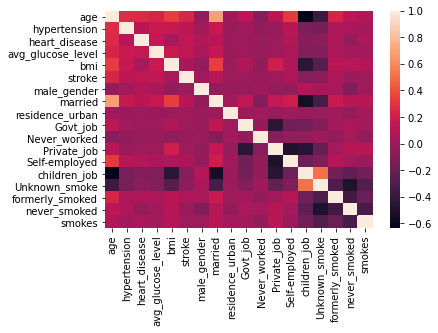

In [42]:
sns.heatmap(stroke_dmy.corr())

### Train/ Test Split <a class="anchor" id="train"></a>

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    stroke_dmy.drop('stroke', axis=1),
    stroke_dmy['stroke'], test_size=0.2)

### Feature Scaling <a class="anchor" id="scale"></a>

In [44]:
from sklearn.preprocessing import StandardScaler 

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

When we look at the value counts for stroke we can see that the data is imbalanced. We will apply SMOTE to combat that.

In [45]:
stroke['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [46]:
from imblearn.over_sampling import SMOTE

In [47]:
sm = SMOTE(random_state=4)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

### Model Selection <a class="anchor" id="mod"></a>

For this section will be using code from [Siddhesh Sawant](https://www.kaggle.com/siddheshera/stroke-eda-smote-9-models-90-accuracy).I was interested in running multiple models at once using a for loop.

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [50]:
models = []
models.append(['Logistic Regreesion', LogisticRegression(random_state=0)])
models.append(['SVM', SVC(random_state=0)])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier(random_state=0)])
models.append(['Random Forest', RandomForestClassifier(random_state=0)])
models.append(['XGBoost', XGBClassifier(eval_metric= 'error')])

lst_1= []

for m in range(len(models)):
    lst_2= []
    model = models[m][1]
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
    accuracies = cross_val_score(estimator = model, X = X_train_res, y = y_train_res, cv = 10)   #K-Fold Validation
    roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
    precision = precision_score(y_test, y_pred)  #Precision Score
    recall = recall_score(y_test, y_pred)  #Recall Score
    f1 = f1_score(y_test, y_pred)  #F1 Score
    print(models[m][0],':')
    print(cm)
    print('Accuracy Score: ',accuracy_score(y_test, y_pred))
    print('')
    print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print('')
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
    print('')
    print('ROC AUC Score: {:.2f}'.format(roc))
    print('')
    print('Precision: {:.2f}'.format(precision))
    print('')
    print('Recall: {:.2f}'.format(recall))
    print('')
    print('F1: {:.2f}'.format(f1))
    print('-----------------------------------')
    print('')
    lst_2.append(models[m][0])
    lst_2.append((accuracy_score(y_test, y_pred))*100) 
    lst_2.append(accuracies.mean()*100)
    lst_2.append(accuracies.std()*100)
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)

Logistic Regreesion :
[[745 231]
 [ 12  34]]
Accuracy Score:  0.7622309197651663

K-Fold Validation Mean Accuracy: 79.15 %

Standard Deviation: 1.41 %

ROC AUC Score: 0.75

Precision: 0.13

Recall: 0.74

F1: 0.22
-----------------------------------

SVM :
[[805 171]
 [ 25  21]]
Accuracy Score:  0.8082191780821918

K-Fold Validation Mean Accuracy: 88.13 %

Standard Deviation: 1.51 %

ROC AUC Score: 0.64

Precision: 0.11

Recall: 0.46

F1: 0.18
-----------------------------------

KNeighbors :
[[827 149]
 [ 34  12]]
Accuracy Score:  0.8209393346379648

K-Fold Validation Mean Accuracy: 91.32 %

Standard Deviation: 0.80 %

ROC AUC Score: 0.55

Precision: 0.07

Recall: 0.26

F1: 0.12
-----------------------------------

GaussianNB :
[[290 686]
 [  0  46]]
Accuracy Score:  0.3287671232876712

K-Fold Validation Mean Accuracy: 64.28 %

Standard Deviation: 1.06 %

ROC AUC Score: 0.65

Precision: 0.06

Recall: 1.00

F1: 0.12
-----------------------------------

BernoulliNB :
[[593 383]
 [  8  38

### Model Tuning <a class="anchor" id="mod_tun"></a>

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0]}]), 
               (KNeighborsClassifier(),[{'n_neighbors':[5,7,8,10], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]), 
               (SVC(),[{'C':[0.25,0.5,0.75,1],'kernel':['linear', 'rbf'],'random_state':[0]}]), 
               (GaussianNB(),[{'var_smoothing': [1e-09]}]), 
               (BernoulliNB(), [{'alpha': [0.25, 0.5, 1]}]), 
               (DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'random_state':[0]}]), 
               (RandomForestClassifier(),[{'n_estimators':[100,150,200],'criterion':['gini','entropy'],'random_state':[0]}]), 
              (XGBClassifier(), [{'learning_rate': [0.01, 0.05, 0.1], 'eval_metric': ['error']}])]

In [53]:
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'accuracy',cv = 10)
    grid.fit(X_train_res, y_train_res)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest Accuracy : {:.2f}%'.format(i,best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')


LogisticRegression():
Best Accuracy : 79.22%
Best Parameters :  {'C': 0.25, 'random_state': 0}

----------------

KNeighborsClassifier():
Best Accuracy : 92.47%
Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 5}

----------------

SVC():
Best Accuracy : 88.13%
Best Parameters :  {'C': 1, 'kernel': 'rbf', 'random_state': 0}

----------------

GaussianNB():
Best Accuracy : 64.28%
Best Parameters :  {'var_smoothing': 1e-09}

----------------

BernoulliNB():
Best Accuracy : 71.81%
Best Parameters :  {'alpha': 0.25}

----------------

DecisionTreeClassifier():
Best Accuracy : 90.73%
Best Parameters :  {'criterion': 'entropy', 'random_state': 0}

----------------

RandomForestClassifier():
Best Accuracy : 96.16%
Best Parameters :  {'criterion': 'entropy', 'n_estimators': 150, 'random_state': 0}

----------------

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, imp

### Model Evaluation <a class="anchor" id="mod_eval"></a>

Now that we have the best hyperparameters we will work with the two best models, Random Forest and XGBoost.

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       976
           1       0.09      0.11      0.10        46

    accuracy                           0.91      1022
   macro avg       0.52      0.53      0.53      1022
weighted avg       0.92      0.91      0.91      1022

ROC AUC score: 0.769478349964362
Accuracy Score:  0.910958904109589


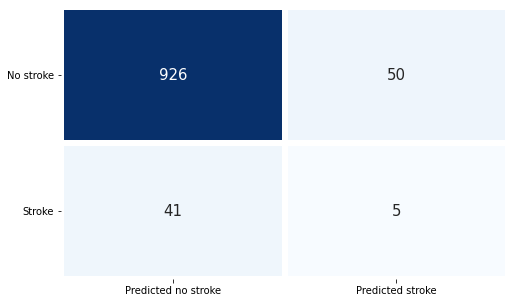

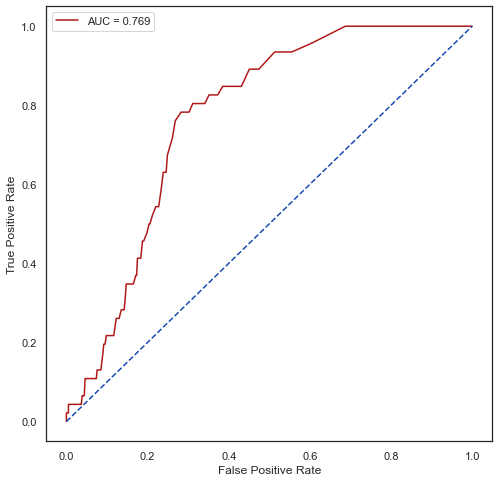

In [54]:
#Fitting RandomForest Model
classifier = RandomForestClassifier(criterion= 'entropy', n_estimators= 150, random_state= 0)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc AUC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       976
           1       0.10      0.13      0.11        46

    accuracy                           0.91      1022
   macro avg       0.53      0.54      0.53      1022
weighted avg       0.92      0.91      0.91      1022

ROC AUC score: 0.7519600855310049
Accuracy Score:  0.9090019569471625


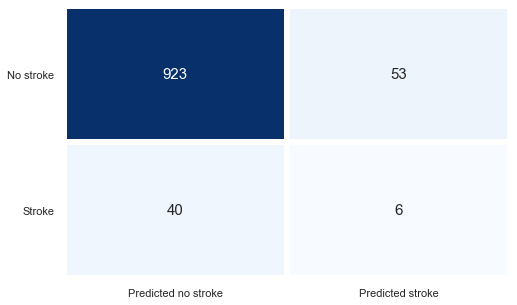

Text(0.5, 0, 'False Positive Rate')

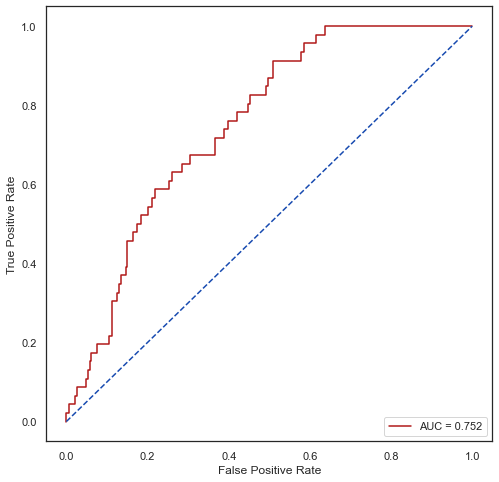

In [55]:
#Fitting XGBClassifier Model
classifier = XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Conclusions <a class="anchor" id="con"></a>

The models do a good job at predicting that someone will not have a stroke, but struggle with predicting if someone will have a stroke. Overall I'm happy with my results.